# **Analysing the Best LDA + SVM Model** #

## **Import Libraries** ##

In [1]:
import os
from tqdm import tqdm  # for the progress bar

import numpy as np
from sklearn.metrics import accuracy_score

import joblib

## **Loading Test Features and Labels** ##

In [2]:
# Function to Load Feature Vectors and Labels
def loadFeaturesAndLabels(features_path):

    features = [] # list to store the feature vectors
    labels = [] # list to store the labels
    
    # checking if the path exists
    if not os.path.exists(features_path):
        raise ValueError(f"Path {features_path} does not exist.")
    # checking if the path is a directory
    if not os.path.isdir(features_path):
        raise ValueError(f"Path {features_path} is not a directory.")
    
    # going through through the folders and load the features
    for fruit_folder in tqdm(os.listdir(features_path), unit="folder", desc=f"Loading Features from {features_path}"):

        fruit_folder_path = os.path.join(features_path, fruit_folder) # creating complete path of the fruit folder
        
        if os.path.isdir(fruit_folder_path):  # checking if it's an valid path to a folder
            for featureVectorFile in os.listdir(fruit_folder_path):

                feature_file_path = os.path.join(fruit_folder_path, featureVectorFile) # creating complete path of the feature file
                
                if featureVectorFile.endswith('.npy'):  # checking if its a valid feature file
                    labels.append(fruit_folder[:-2].strip())  # the folder name is the label (not taking the numbers at the end)

                    featureVector = np.load(feature_file_path)
                    features.append(featureVector)
                    
                    
    return np.array(features), np.array(labels)

In [3]:
testFeatures, testLabels = loadFeaturesAndLabels('../features/img_ColourHist_LBP_Hist_Features/Testing')
print(f"Testing Features Shape: {testFeatures.shape}")
print(f"Number of Labels: {len(np.unique(testLabels))}")


# using StandardScaler to standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
testFeatures = scaler.fit_transform(testFeatures)

Loading Features from ../features/img_ColourHist_LBP_Hist_Features/Testing: 100%|██████████| 159/159 [00:03<00:00, 46.84folder/s]

Testing Features Shape: (26668, 70)
Number of Labels: 131


## **Loading LDA Model 3** ##

In [ ]:
# loading LDA Model 3
lda_model_filename = '../saved_models/LDA_Model_3.pkl'
LDA_Model = joblib.load(lda_model_filename)

# number of features in LDA Model 3
print(f"Number of Features in LDA: {LDA_Model.scalings_.shape[1]}")

# predicitng using LDA Model 3
testPredictions_LDA = LDA_Model.predict(testFeatures)

# finding the accuracy
accuracy = accuracy_score(testLabels, testPredictions_LDA)
print(f"LDA Classifier Accuracy: {accuracy*100:.2f}%")

Number of Features in LDA: 61
LDA Classifier Accuracy: 89.79%


## **Analyzing LDA + SVM Model 3** ##

### **Number of Test Samples and Test Features** ### 

In [5]:
# loading LDA + SVM Model 3
lda_svm_model_filename = '../saved_models/LDA_SVM_Model_3.pkl'
LDA_SVM_Model = joblib.load(lda_svm_model_filename)

# transforming the features using LDA Model 3 for LDA + SVM Model 3
testFeaturesLDA = LDA_Model.transform(testFeatures)
print(f"Number of Test Samples: {testFeaturesLDA.shape[0]}")
print(f"Numder of Features in LDA + SVM Model: {testFeaturesLDA.shape[1]}")

Number of Test Samples: 26668
Numder of Features in LDA + SVM Model: 61


### **Plotting the LDA Transformed Test Features** ###

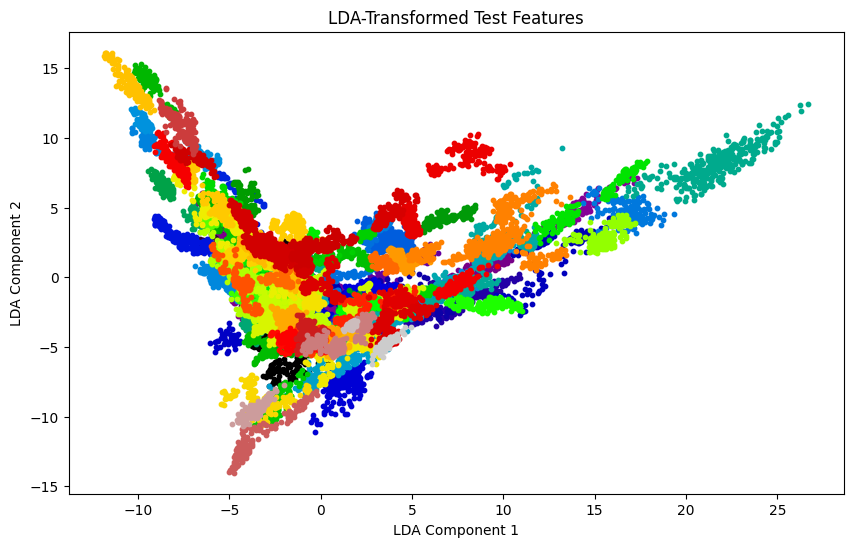

In [31]:
import matplotlib.pyplot as plt

# visualizing 2 LDA-transformed test features
plt.figure(figsize=(10, 6))
uniqueLabels = np.unique(testLabels)
colours = plt.cm.nipy_spectral(np.linspace(0, 1, len(uniqueLabels)))  # continuous colormap for 132 classes

for label, colour in zip(uniqueLabels, colours):
    l = (testLabels == label)
    plt.scatter(testFeaturesLDA[l, 0], testFeaturesLDA[l, 1], 
                color=colour, s=10)  # s=10 for smaller marker size

plt.title('LDA-Transformed Test Features')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.show()

### **Test Accuracy** ###

In [6]:
# predicitng using LDA + SVM Model 3
testPredictions_LDA_SVM = LDA_SVM_Model.predict(testFeaturesLDA)

# finding the accuracy
accuracy = accuracy_score(testLabels, testPredictions_LDA_SVM)
print(f"Best LDA + SVM Classifier Test Accuracy: {accuracy*100:.2f}%")

Best LDA + SVM Classifier Test Accuracy: 99.23%


### **Confusion Matrix** ###

#### **Plotting Confusion Matrix** ####

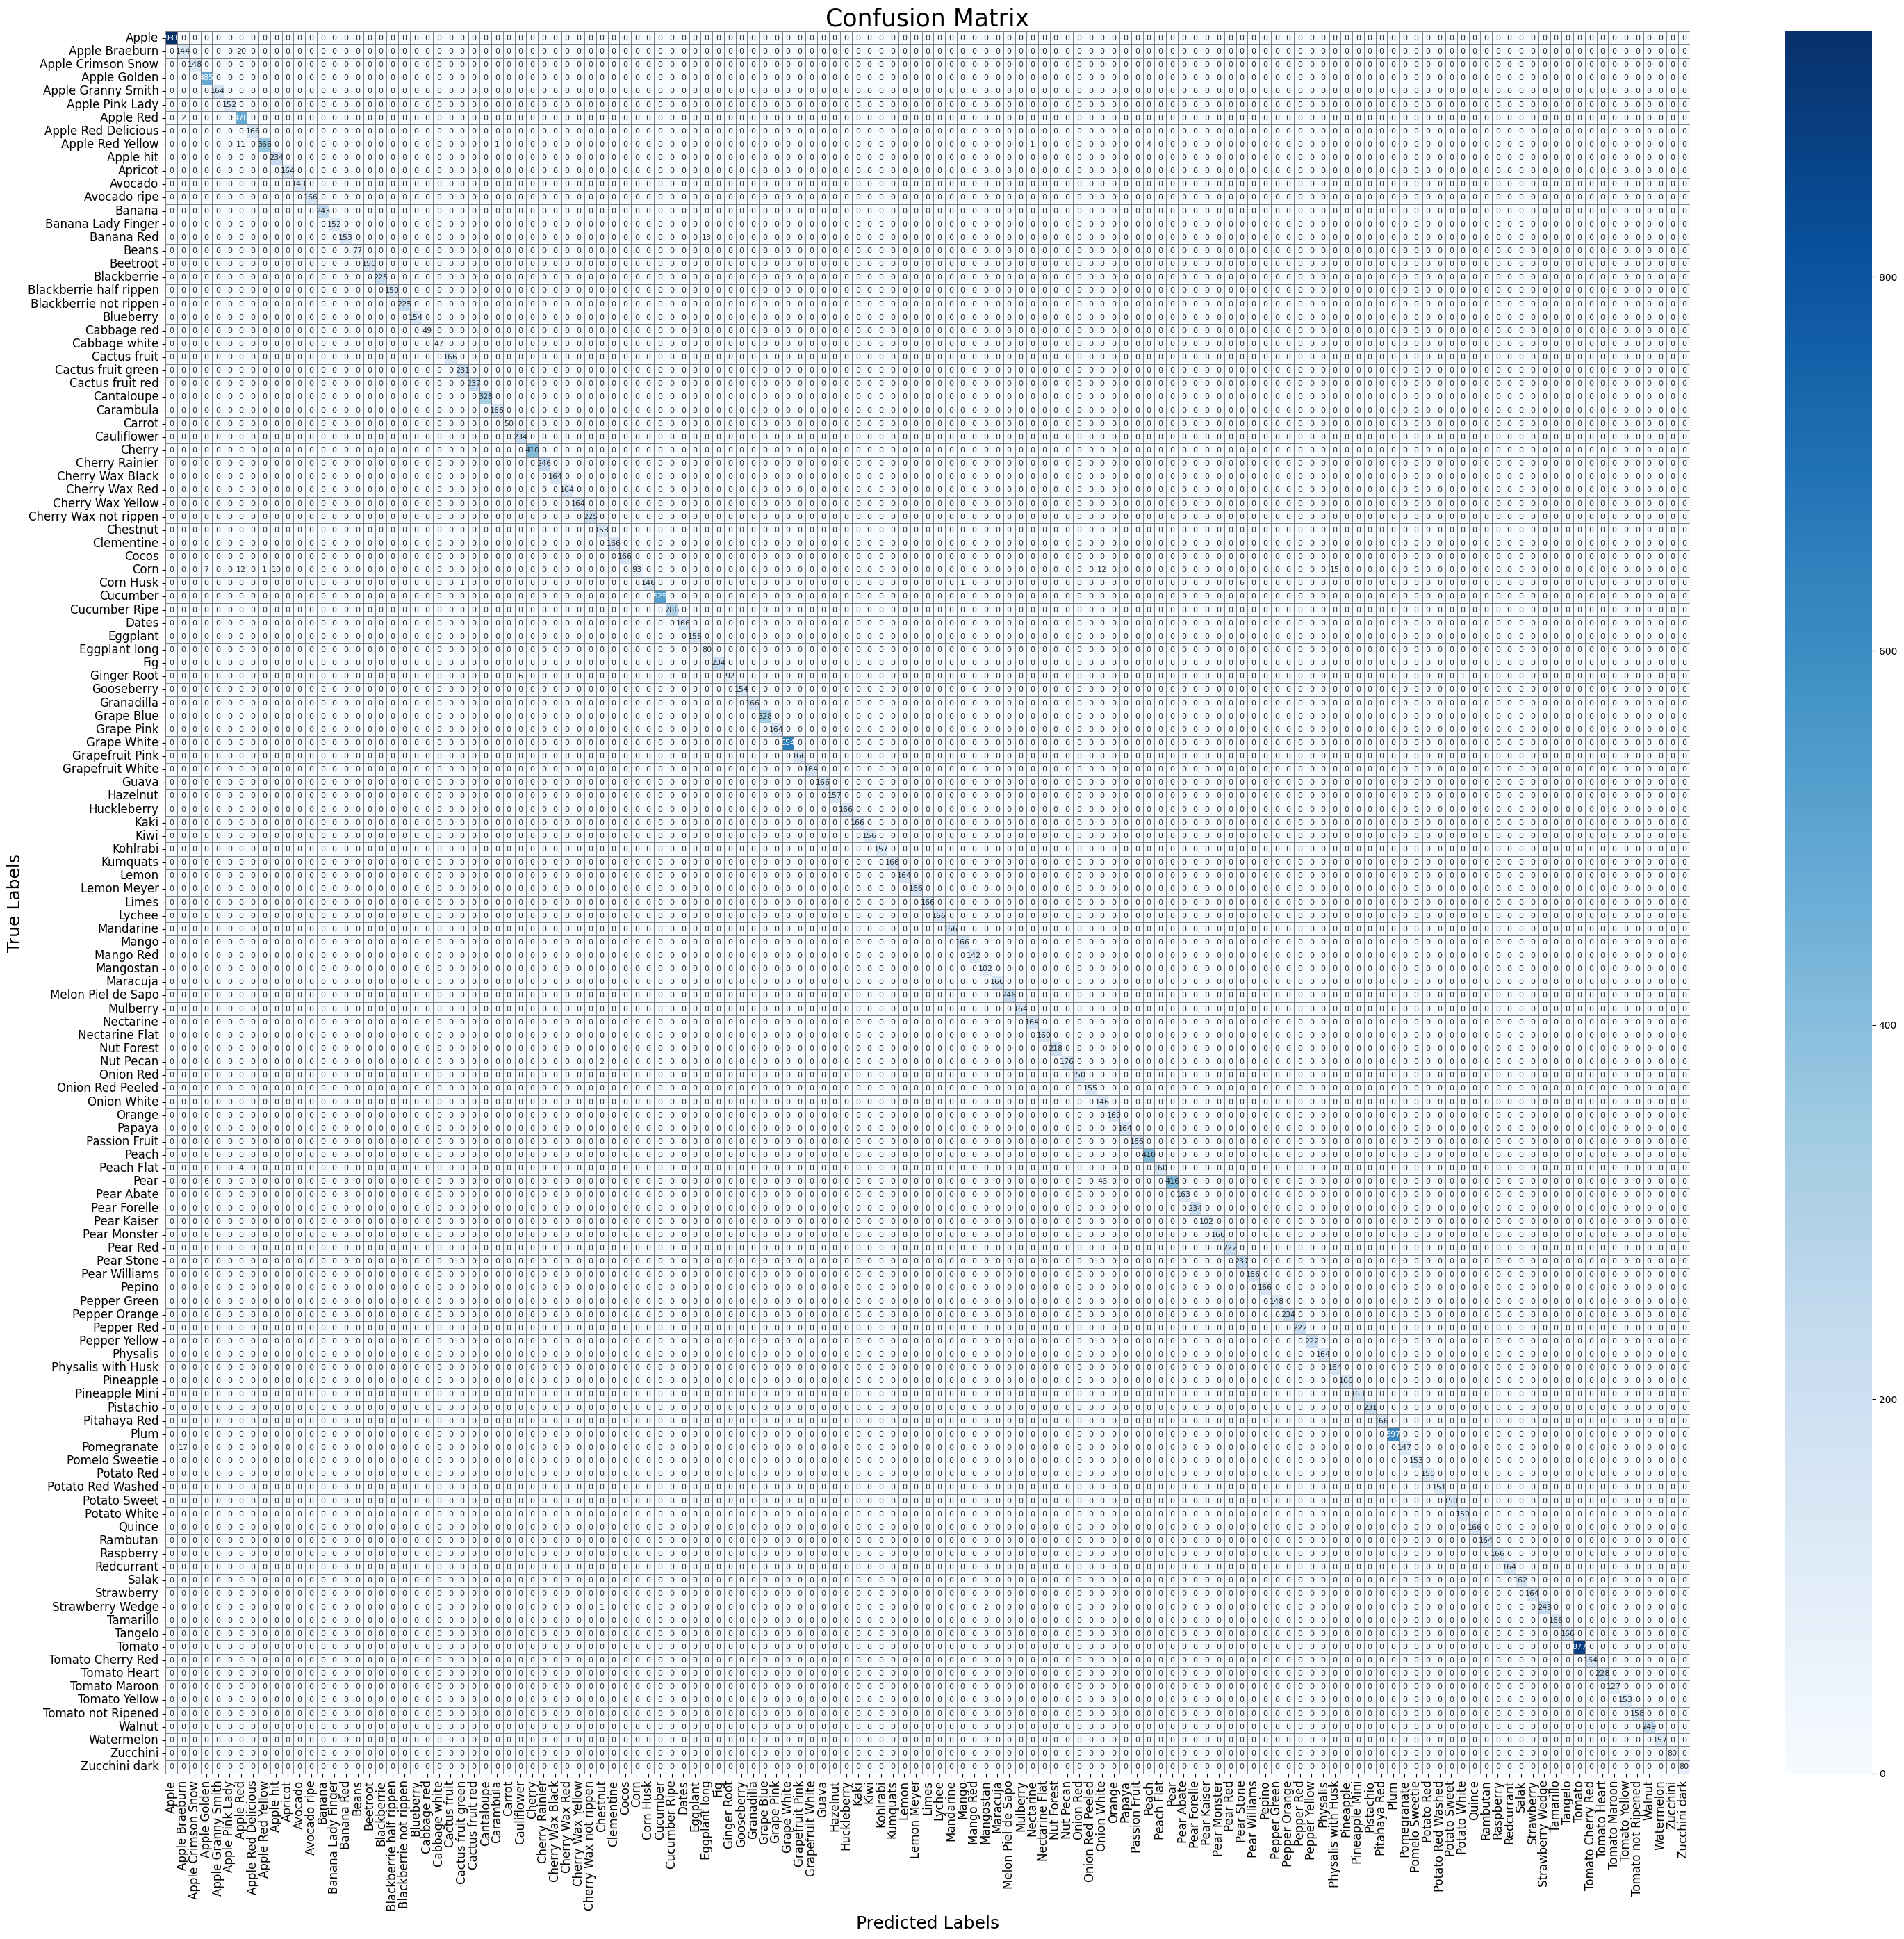

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import confusion_matrix

unique_labels = np.unique(testLabels) # getting unique labels

# generating confusion matrix
confusionMatrix = confusion_matrix(testLabels, testPredictions_LDA_SVM, labels=unique_labels)

# plotting confusion matrix
plt.figure(figsize=(30, 28))  # Bigger figure
seaborn.heatmap(
            confusionMatrix, 
            
            xticklabels=unique_labels, # x-axis labels
            yticklabels=unique_labels, # y-axis labels

            cmap='Blues',      # color map
            cbar=True,         # color bar

            linewidths=0.5,    # lines between cells
            linecolor='gray',  # line color

            annot=True,             # show numbers
            fmt='d',                # integer format
            annot_kws={"size": 8}  # font size inside boxes
)

plt.title('Confusion Matrix', fontsize=25)

plt.xlabel('Predicted Labels', fontsize=18)
plt.xticks(fontsize=12, rotation=90) # to prevent overlap

plt.ylabel('True Labels', fontsize=18)
plt.yticks(fontsize=12, rotation=0)

plt.tight_layout()  
plt.show()

# saving the confusion matrix as image
plt.savefig('../confusionMatrix_LDA_SVM_Model_3.png')


#### **Tabulating Misclassifications from the Confusion Matrix** ####

In [26]:
import numpy as np

misclassifications = []
count = 0

for trueIndex in range(len(unique_labels)):
    for predIndex in range(len(unique_labels)):
        if trueIndex != predIndex and confusionMatrix[trueIndex, predIndex] > 0:
            misclassifications.append((unique_labels[trueIndex], unique_labels[predIndex], confusionMatrix[trueIndex, predIndex]))
            count += confusionMatrix[trueIndex, predIndex]

misclassifications.sort(key=lambda x: x[2], reverse=True) # sorting misclassifications by count in descending order

print(f"\nTotal Misclassifications: {count}\n")
print(f"{'True Label':<20} {'Predicted Label':<20} {'Count'}")
print("-" * 50)
for true_label, pred_label, count in misclassifications:
    print(f"{true_label:<20} {pred_label:<20} {count}")


Total Misclassifications: 205

True Label           Predicted Label      Count
--------------------------------------------------
Pear                 Onion White          46
Apple Braeburn       Apple Red            20
Pomegranate          Apple Braeburn       17
Corn                 Physalis with Husk   15
Banana Red           Eggplant long        13
Corn                 Apple Red            12
Corn                 Onion White          12
Apple Red Yellow     Apple Red            11
Corn                 Apple hit            10
Corn                 Apple Golden         7
Corn Husk            Pear Stone           6
Ginger Root          Cauliflower          6
Pear                 Apple Golden         6
Apple Red Yellow     Peach                4
Peach Flat           Apple Red            4
Pear Abate           Banana Red           3
Apple Red            Apple Braeburn       2
Nut Pecan            Chestnut             2
Strawberry Wedge     Mangostan            2
Apple Red Yellow     Car